# Lab Assignment 6

## Austin Booth

Link:

### Exercise 1

In [1]:
# standard imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tclab import setup, Historian, Plotter, clock

In [33]:
# set ambient temperature and initialize disturbance and x variables
from tclab import TCLab, setup, clock, Historian, Plotter

with TCLab() as lab:
    T1 = lab.T1
    T2 = lab.T2
    Tamb = (T1 + T2) / 2
    print('T_amb:', Tamb)
    
d_initial = [Tamb]                       # initial disturbance input
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])       # initial steady state

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
T_amb: 28.472
TCLab disconnected successfully.


In [5]:
# construct matrices based on Lab 5 results

# define parameters from Lab 2
CpH = 8.7738
CpS = 2.9110
Ua = 0.0495195
Ub = 0.273355
Uc = 0.0387042

# constant parameters
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# construct arrays
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH], [0, 0, Ub/CpS, -Ub/CpS]])  # 4x4
Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])     # 4x2
Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])           # 4x1
C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])                   # 2x4

# print arrays
print('A:')
print(A)
print('Bu:')
print(Bu)
print('Bd:')
print(Bd)
print('C:')
print(C)

A:
[[-0.04121119  0.03115583  0.00441134  0.        ]
 [ 0.09390416 -0.09390416  0.          0.        ]
 [ 0.00441134  0.         -0.04121119  0.03115583]
 [ 0.          0.          0.09390416 -0.09390416]]
Bu:
[[0.00364722 0.        ]
 [0.         0.        ]
 [0.         0.00182361]
 [0.         0.        ]]
Bd:
[[0.00564402]
 [0.        ]
 [0.00564402]
 [0.        ]]
C:
[[0 1 0 0]
 [0 0 0 1]]


In [20]:
# define observer function as presented in assignment notebook

def tclab_observer(L, x_initial, d_hat):
    
    # initialize
    t = 0
    x_hat = x_initial
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state and measurement error.
        # wait for message with next time, last control input, and measurement
        t, u, y = yield x_hat, y_err
        
        # update model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A, x_hat) + np.dot(Bu, u) + np.dot(Bd, d_hat))
        y_pred = np.dot(C, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L, y_err)

In [21]:
# define experiment function as presented in assignment notebook

def experiment(observer, u1, u2, t_final=400, t_step=2):
        
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1, lab.T2]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

### L = 1 * eigenvalues of A

In [22]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 1*evals)
L = results.gain_matrix.T

print(L)

[[-1.39185193e-05  1.87549414e-06]
 [-1.87409306e-04  5.42169635e-06]
 [-5.15313078e-06  1.42930158e-05]
 [ 8.21350437e-06  1.87409306e-04]]


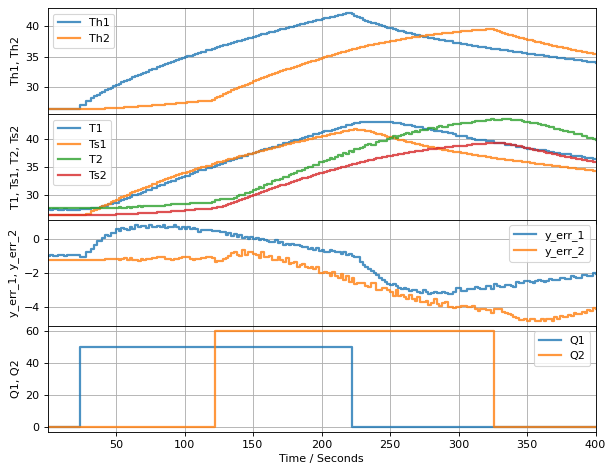

TCLab disconnected successfully.


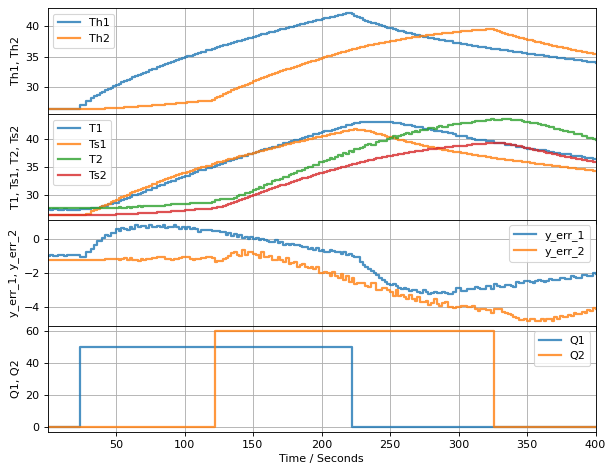

In [23]:
# run observer experiment with this L matrix

def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

### L = 2 * eigenvalues of A

In [24]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 2*evals)
L = results.gain_matrix.T

print(L)

[[-0.02943671 -0.00496023]
 [ 0.13469157 -0.00439409]
 [-0.00495174 -0.02924054]
 [-0.00438094  0.13553911]]


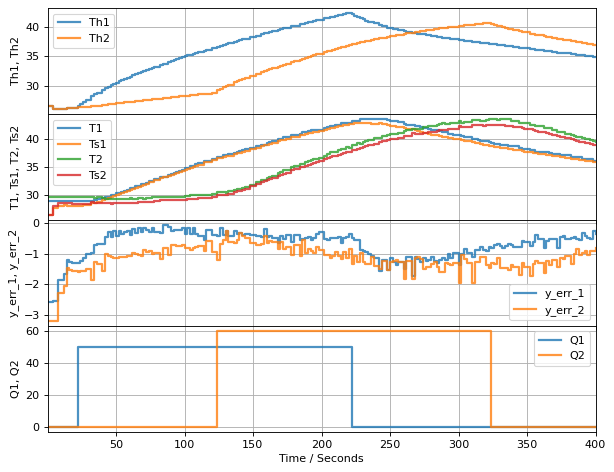

TCLab disconnected successfully.


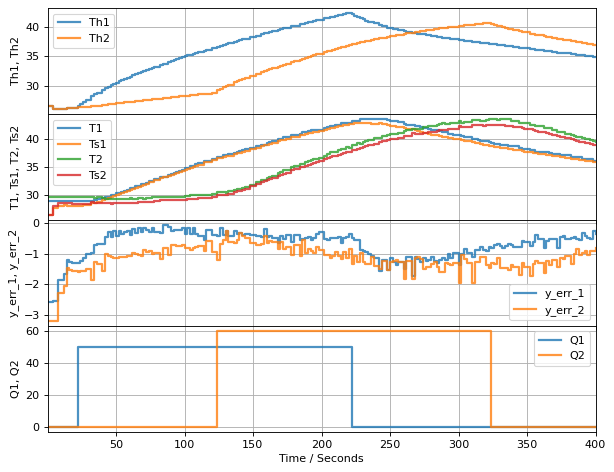

In [25]:
# run observer experiment with this L matrix

def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

### L = 5 * eigenvalues of A

In [28]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 5*evals)
L = results.gain_matrix.T

print(L)

[[ 0.00335292 -0.0727295 ]
 [ 0.54055245 -0.01764166]
 [-0.0727484   0.00326784]
 [-0.01764791  0.54037029]]


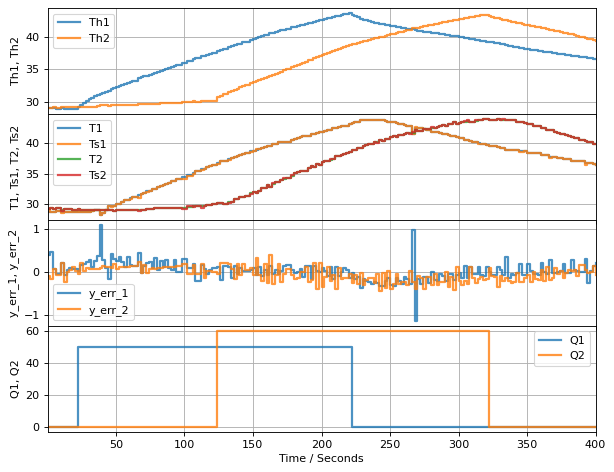

TCLab disconnected successfully.


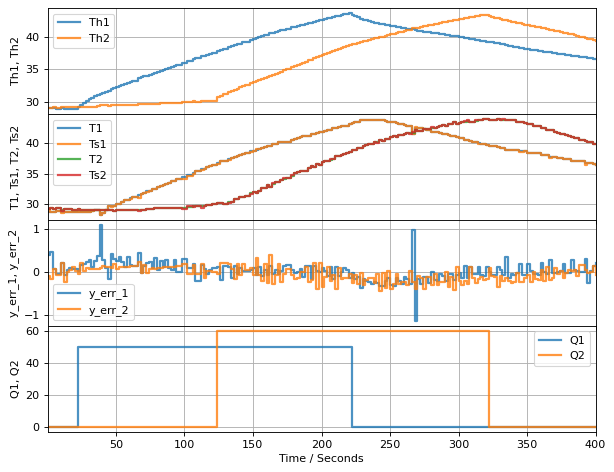

In [29]:
# run observer experiment with this L matrix

def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

### L = 10 * eigenvalues of A

In [39]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 10*evals)
L = results.gain_matrix.T

print(L)

[[ 0.4603217  -0.36208058]
 [ 1.2163858  -0.03968352]
 [-0.36226191  0.45955516]
 [-0.03971193  1.21569036]]


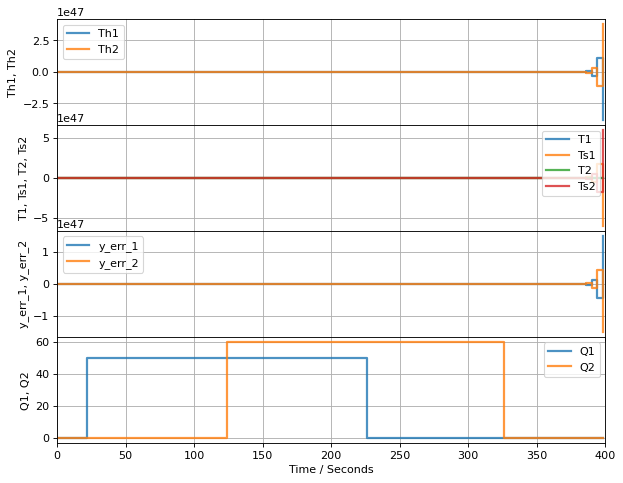

TCLab disconnected successfully.


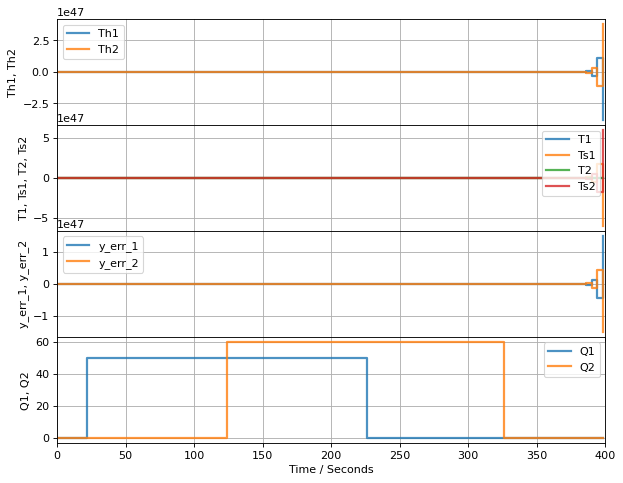

In [40]:
# run observer experiment with this L matrix

def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

I would recommend the third L matrix, with eigenvalues 5 times that of A alone, for production use. 

The first and second matrices resulted in observer functions that approximated the sensor temperature but still had error within a few degrees C at most points. The third matrix predicted and tracked sensor temperature very closely and gave reasonable predictions of heater temperature, with error only within a few tenths of a degree at most points. 

The last L matrix, with eigenvalues 10 times that of A alone, resulted in extreme oscillations and impossible temperature predictions that appeared to grow exponentially. The reason for this is unclear; this pattern occurred reliably and persisted through troubleshooting. It is possible that the matrix actually had negative real eigenvalues that caused extreme deviation.

Some deviation is likely also due to changing values and approximations of ambient temperature over time. Bad estimates of initial ambient temperature certainly affected the efficacy of the first and second L matrices by providing an initial offset that the model had to work to overcome.

### Exercise 2

In [41]:
from scipy.signal import place_poles

A_aug = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
Bu_aug = np.vstack([Bu, [[0, 0]]])
Bd_aug = np.vstack([np.zeros([4, 1]), [[1]]])
C_aug = np.hstack([C, np.zeros([2, 1])])

# print arrays
print('A_aug:')
print(A_aug)
print('Bu_aug:')
print(Bu_aug)
print('Bd_aug:')
print(Bd_aug)
print('C_aug:')
print(C_aug)

A_aug:
[[-0.04121119  0.03115583  0.00441134  0.          0.00564402]
 [ 0.09390416 -0.09390416  0.          0.          0.        ]
 [ 0.00441134  0.         -0.04121119  0.03115583  0.00564402]
 [ 0.          0.          0.09390416 -0.09390416  0.        ]
 [ 0.          0.          0.          0.          0.        ]]
Bu_aug:
[[0.00364722 0.        ]
 [0.         0.        ]
 [0.         0.00182361]
 [0.         0.        ]
 [0.         0.        ]]
Bd_aug:
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]]
C_aug:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [42]:
# place eigenvalues
# 5*eigenvalues was best result from Exercise 1
# choose 5th eigenvalue as -1/50 = -0.02 (time constant 50 seconds)

evals, _ = np.linalg.eig(A)

newEvals = np.hstack([5*evals, -0.02])

results = place_poles(A_aug.T, C_aug.T, newEvals)

L_aug = results.gain_matrix.T
print(L_aug)

[[0.07575    0.19884595]
 [0.55045656 0.03646889]
 [0.19883683 0.07576191]
 [0.03646716 0.55046618]
 [0.64077384 0.64082129]]


In [43]:
# set ambient temperature and initialize disturbance and x variables
from tclab import TCLab, setup, clock, Historian, Plotter

with TCLab() as lab:
    T1 = lab.T1
    T2 = lab.T2
    Tamb = (T1 + T2) / 2
    print('T_amb:', Tamb)
    
d_initial = [Tamb]                       # initial disturbance input
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])       # initial steady state

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
T_amb: 27.569499999999998
TCLab disconnected successfully.


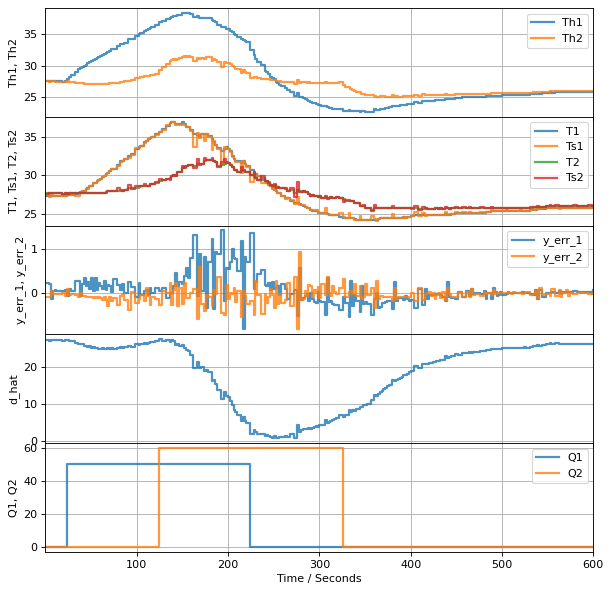

TCLab disconnected successfully.


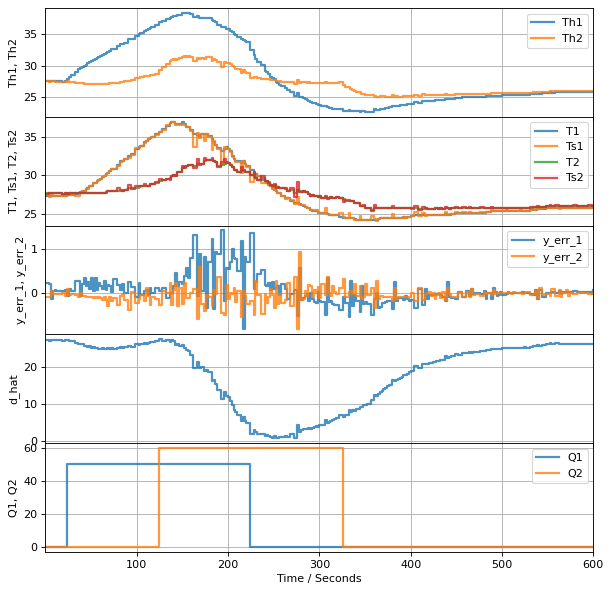

In [46]:
# define observer and experiment functions to use live lab and real measurements

def tclab_observer_disturbance(L_aug, x_initial, d_hat):
    
    # initialize
    x_hat = np.hstack([x_initial, d_hat])
    print(x_hat)
    t = 0
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state and measurement error.
        # wait for message with next time, last control input, and measurement
        t, u, y = yield x_hat, y_err
        
        # model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A_aug, x_hat) + np.dot(Bu_aug, u))
        y_pred = np.dot(C_aug, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L_aug, y_err)
                       
                       
def experiment_disturbance(observer, u1, u2, t_final=400, t_step=2):
    
    # open connection to tclab
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('d_hat', lambda: x[4]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['d_hat'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1, lab.T2]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

observer = tclab_observer_disturbance(L_aug, x_initial, d_initial)
experiment_disturbance(observer, u1, u2, t_final=600)

I introduced a disturbance around t = 150 seconds by moving the TCLab into an area where a fan was blowing and opening the window behind the fan to introduce more cool air. I shut off the fan and closed the window again around t = 350 seconds. Yes, the disturbance estimator detected this change and tracked it very well, considering the randomness that comes with a blowing fan. Predicted values were usually within 1 degree C of actual values.